# 4. Kỹ thuật xây dựng đặc trưng (Feature Engineering)

Trong notebook này, chúng ta sẽ xây dựng các đặc trưng hữu ích từ dữ liệu đã được mã hóa. Việc xây dựng đặc trưng đóng vai trò quan trọng trong việc cải thiện hiệu suất của mô hình phân loại.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Thiết lập để hiển thị biểu đồ đẹp hơn
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Để hiển thị Tiếng Việt đúng
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Đọc dữ liệu đã mã hóa
df = pd.read_csv('../clean_data/vnexpress_encoded_data.csv', encoding='utf-8-sig')

print(f"Kích thước dữ liệu: {df.shape}")
print(f"Số lượng bài viết theo nhóm:\n{df['group'].value_counts()}")

Kích thước dữ liệu: (1182, 200)
Số lượng bài viết theo nhóm:
group
Công nghệ    604
Khoa học     578
Name: count, dtype: int64


## 4.1. Tạo đặc trưng mới

Chúng ta sẽ tạo một số đặc trưng mới từ dữ liệu hiện có để cung cấp thông tin bổ sung cho mô hình.

In [3]:
# 1. Tạo đặc trưng tỷ lệ tiêu đề/nội dung
df['title_content_ratio'] = df['title_length'] / df['content_length']

# 2. Tạo đặc trưng tỷ lệ mô tả/nội dung
df['desc_content_ratio'] = df['description_length'] / df['content_length']

# 3. Tỷ lệ bình luận trên độ dài nội dung
df['comments_per_content_length'] = df['nums_of_comments'] / df['content_length']

# 4. Đánh dấu thời gian đăng bài
# Sáng (6-11), trưa (11-14), chiều (14-18), tối (18-23), đêm khuya (23-6)

df['time_of_day'] = pd.cut(
    df['hour'],
    bins=[0, 6, 11, 14, 18, 23],
    labels=['Đêm khuya', 'Sáng', 'Trưa', 'Chiều', 'Tối'],
    include_lowest=True
)


# 5. Đánh dấu ngày trong tuần (ngày làm việc vs cuối tuần)
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 5 = Thứ 7, 6 = Chủ nhật

# 6. Tạo đặc trưng "độ phức tạp" của văn bản
# df['text_complexity'] = df['content_length'] / (df['content'].apply(lambda x: len(x.split())) + 1)

df['text_complexity'] = df['content_length'] / (
    df['content'].fillna("").astype(str).apply(lambda x: len(x.split())) + 1
)


# Hiển thị các đặc trưng mới
new_features = ['title_content_ratio', 'desc_content_ratio', 'comments_per_content_length', 'time_of_day', 'is_weekend', 'text_complexity']
df[new_features].describe()

,title_content_ratio,desc_content_ratio,comments_per_content_length,is_weekend,text_complexity
count,1182.000000,1182.000000,1181.000000,1182.000000,1182.000000
mean,inf,inf,inf,0.252961,4.452711
std,NaN,NaN,NaN,0.434893,0.355439
min,0.003359,0.010099,0.000000,0.000000,0.000000
25%,0.013886,0.038953,0.000855,0.000000,4.436291
50%,0.019266,0.053798,0.005261,0.000000,4.503319
75%,0.025441,0.069020,0.017984,1.000000,4.572999
max,inf,inf,inf,1.000000,6.750000


### 4.1.1. Trực quan hóa các đặc trưng mới

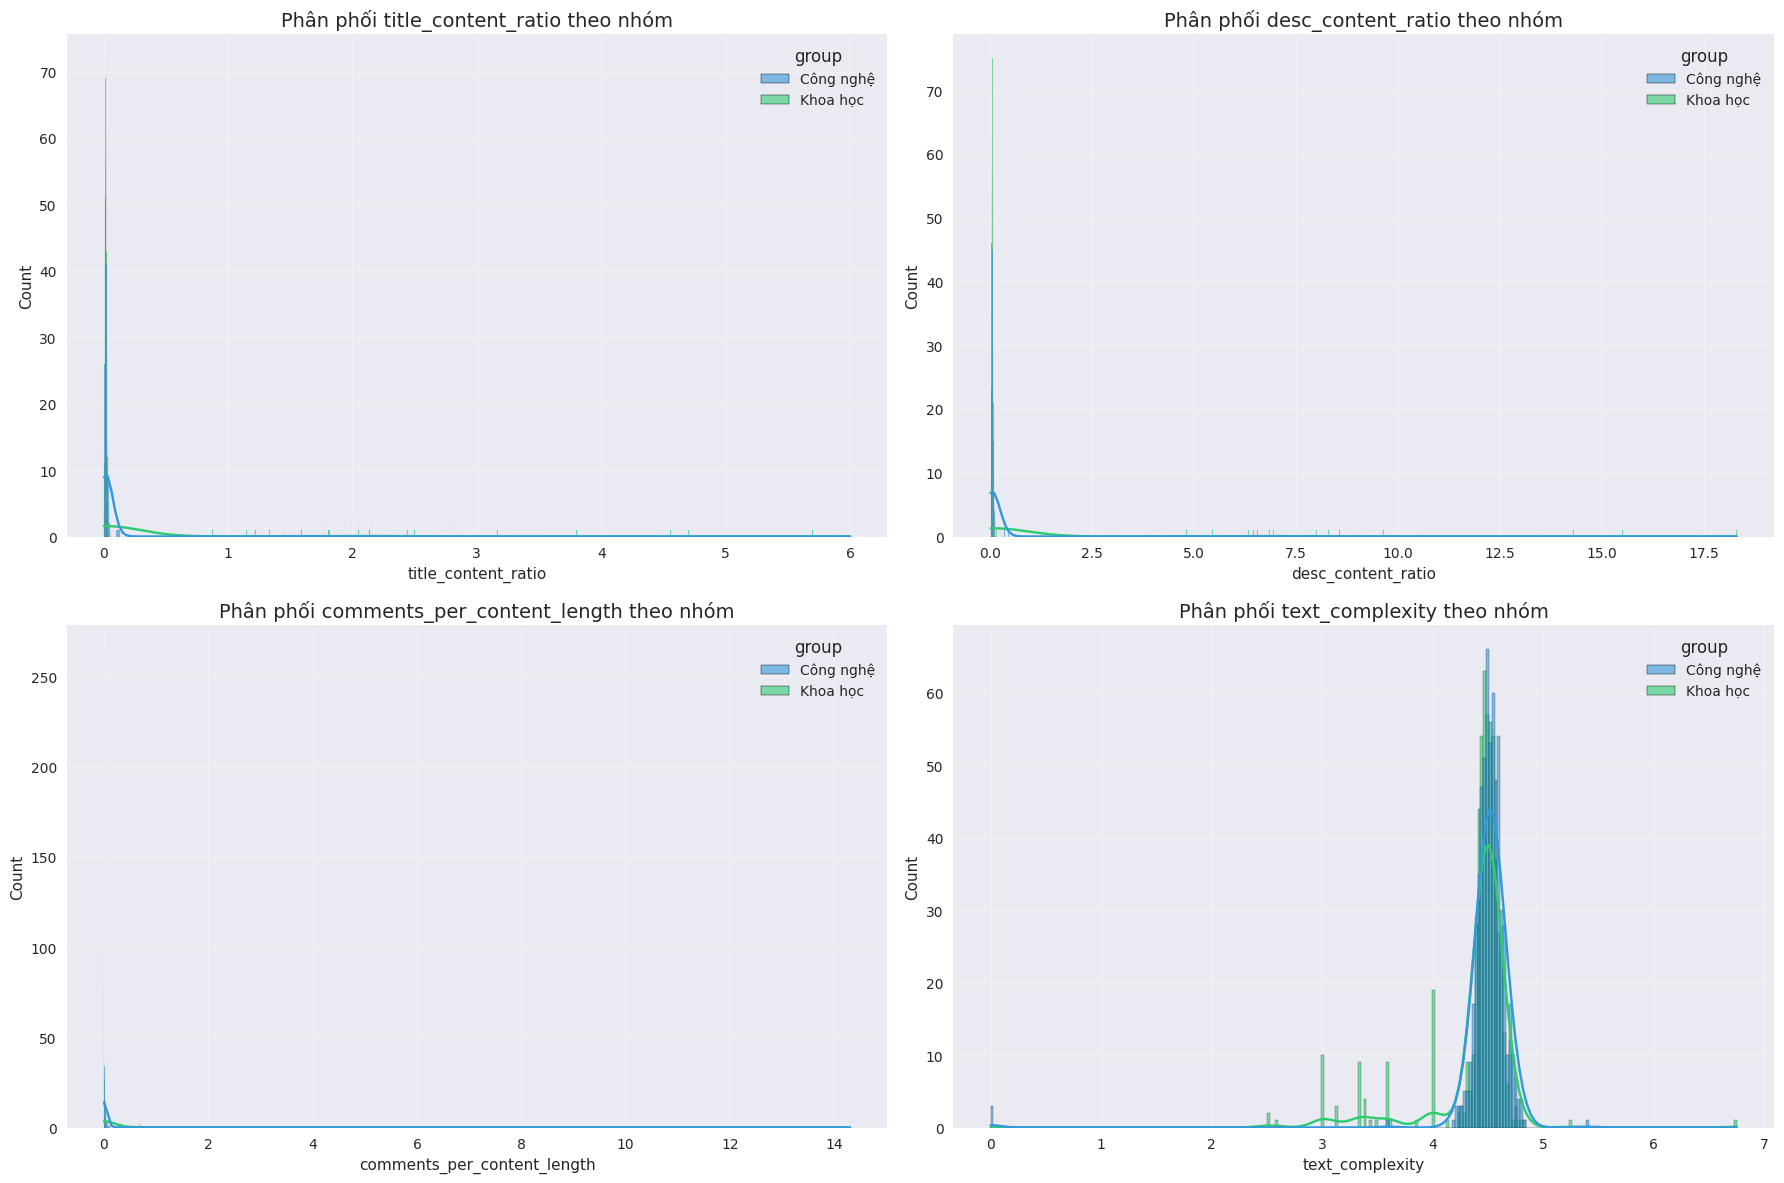

In [4]:
# Trực quan hóa phân phối các đặc trưng số mới theo nhóm
numeric_features = ['title_content_ratio', 'desc_content_ratio', 'comments_per_content_length', 'text_complexity']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(
        data=df, 
        x=feature, 
        hue='group', 
        ax=axes[i], 
        kde=True,
        palette=['#3498db', '#2ecc71'],
        alpha=0.6
    )
    axes[i].set_title(f'Phân phối {feature} theo nhóm', fontsize=14)
    axes[i].grid(alpha=0.3)
    
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

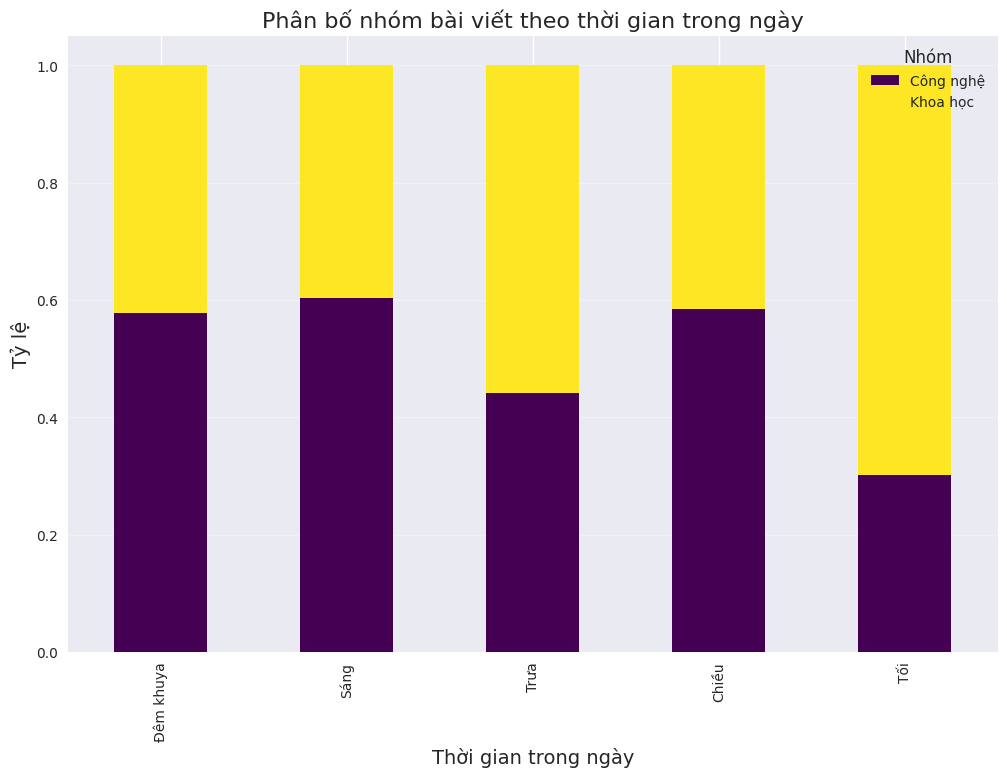

In [5]:
# Trực quan hóa đặc trưng time_of_day theo nhóm
plt.figure(figsize=(14, 7))
time_group = pd.crosstab(df['time_of_day'], df['group'], normalize='index')
time_group.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Phân bố nhóm bài viết theo thời gian trong ngày', fontsize=16)
plt.xlabel('Thời gian trong ngày', fontsize=14)
plt.ylabel('Tỷ lệ', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Nhóm')
plt.show()

## 4.2. Phân tích tính quan trọng của đặc trưng

Chúng ta sẽ sử dụng các phương pháp thống kê để đánh giá tầm quan trọng của các đặc trưng đối với bài toán phân loại.

In [6]:
# Chuẩn bị dữ liệu
# Chọn các cột số làm đặc trưng
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Loại bỏ các cột không phải đặc trưng
excluded_cols = ['nums_of_comments', 'title_length', 'description_length', 'content_length',
                'title_cleaned_length', 'description_cleaned_length', 'content_cleaned_length',
                'tags_count', 'hour', 'day_of_week', 'month', 'year']

# Lọc các cột số để lấy đặc trưng cho phân tích
feature_cols = [col for col in numeric_cols if col not in excluded_cols]

# Tạo X, y cho phân tích đặc trưng
X_features = df[feature_cols]
y = (df['group'] == 'Công nghệ').astype(int)  # 1 cho Công nghệ, 0 cho Khoa học

print(f"Số lượng đặc trưng: {X_features.shape[1]}")

Số lượng đặc trưng: 177


### 4.2.1. Loại bỏ giá trị cực đoan trong các đặc trưng số

In [7]:
# Xử lý giá trị vô cùng và NaN
X_features = X_features.replace([np.inf, -np.inf], np.nan)
X_features.fillna(0, inplace=True)

# Xử lý outlier bằng cách cắt ngưỡng (clipping)
# Chỉ áp dụng cho các đặc trưng tạo mới, không áp dụng cho các đặc trưng TF-IDF
clip_features = ['title_content_ratio', 'desc_content_ratio', 'comments_per_content_length', 'text_complexity']

for col in clip_features:
    if col in X_features.columns:
        q1 = X_features[col].quantile(0.01)
        q3 = X_features[col].quantile(0.99)
        X_features[col] = X_features[col].clip(q1, q3)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_features),
    columns=X_features.columns
)

### 4.2.2. Sử dụng Chi2 để chọn đặc trưng quan trọng

Phương pháp Chi2 thích hợp cho bài toán phân loại và có thể đánh giá tính quan trọng của các đặc trưng không âm.

In [8]:
# Với chi2, các giá trị phải không âm. Chúng ta cần MinMaxScaler
mm_scaler = MinMaxScaler()
X_mm_scaled = mm_scaler.fit_transform(X_features)

# Chọn đặc trưng với Chi2
k_best = min(30, X_features.shape[1])  # Chọn tối đa 30 đặc trưng hoặc tất cả nếu số đặc trưng < 30
chi2_selector = SelectKBest(chi2, k=k_best)
chi2_selector.fit(X_mm_scaled, y)

# Lấy điểm số và p-value
chi2_scores = pd.DataFrame(
    {'feature': X_features.columns,
     'chi2_score': chi2_selector.scores_,
     'p_value': chi2_selector.pvalues_}
)

# Sắp xếp theo điểm số giảm dần
chi2_scores = chi2_scores.sort_values('chi2_score', ascending=False)

# Hiển thị top 20 đặc trưng quan trọng nhất
chi2_scores.head(20)

,feature,chi2_score,p_value
2,category_Khoa học,309.314879,3.079458e-69
63,category_Khoa học.1,309.314879,3.079458e-69
4,category_Nhịp sống số,164.596026,1.120876e-37
65,category_Nhịp sống số.1,164.596026,1.120876e-37
6,category_Thiết bị,124.403974,6.872581e-29
67,category_Thiết bị.1,124.403974,6.872581e-29
61,category_AI.1,119.619205,7.664812e-28
0,category_AI,119.619205,7.664812e-28
10,category_Vũ trụ,84.643599,3.572989e-20
71,category_Vũ trụ.1,84.643599,3.572989e-20


Chi-squared feature selection output explanation:

This cell shows the top 20 most important features according to the chi-squared test:
- Each row represents a feature
- 'chi2_score' column shows the chi-squared statistic value for each feature
- 'p_value' column shows the statistical significance of the feature
- Features are sorted by chi2_score in descending order

The higher the chi2_score and lower the p_value, the more significant that feature is for 
distinguishing between technology and science articles. TF-IDF features from specific words 
that are strongly associated with either technology or science categories will have high scores.

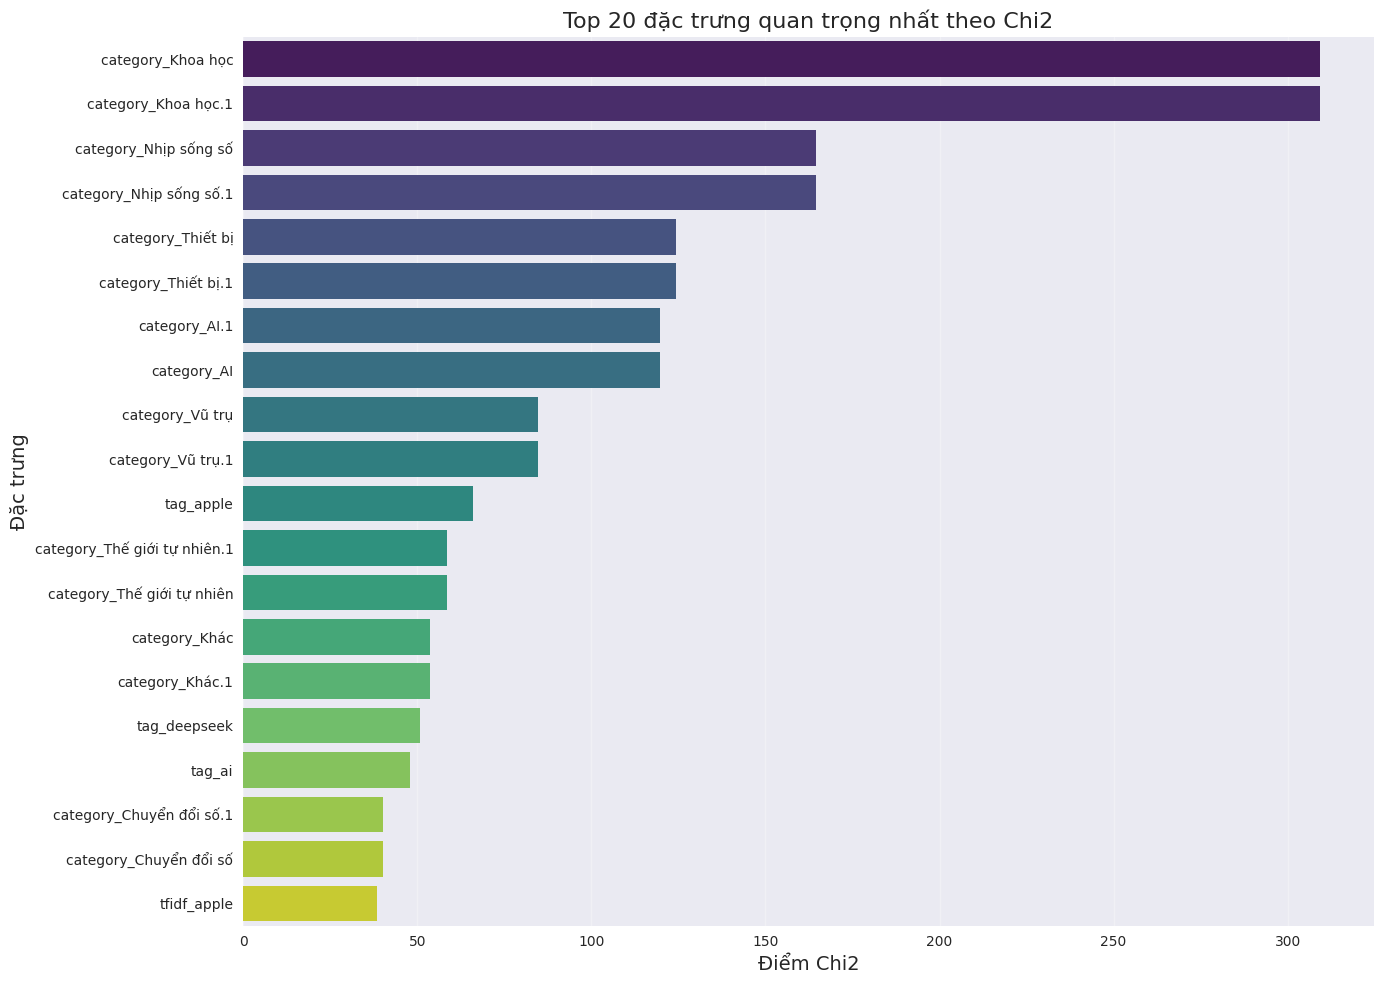

In [9]:
# Trực quan hóa top 20 đặc trưng quan trọng nhất theo Chi2
plt.figure(figsize=(14, 10))
top_20_features = chi2_scores.head(20)
sns.barplot(x='chi2_score', y='feature', data=top_20_features, palette='viridis')
plt.title('Top 20 đặc trưng quan trọng nhất theo Chi2', fontsize=16)
plt.xlabel('Điểm Chi2', fontsize=14)
plt.ylabel('Đặc trưng', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2.3. Sử dụng ANOVA F-value cho việc chọn đặc trưng

ANOVA F-value là một phương pháp thống kê khác để đánh giá tầm quan trọng của các đặc trưng cho bài toán phân loại.

In [10]:
# Sử dụng ANOVA F-value để chọn đặc trưng
f_selector = SelectKBest(f_classif, k=k_best)
f_selector.fit(X_scaled, y)

# Lấy điểm số và p-value
f_scores = pd.DataFrame(
    {'feature': X_features.columns,
     'f_score': f_selector.scores_,
     'p_value': f_selector.pvalues_}
)

# Sắp xếp theo điểm số giảm dần
f_scores = f_scores.sort_values('f_score', ascending=False)

# Hiển thị top 20 đặc trưng quan trọng nhất
f_scores.head(20)

,feature,f_score,p_value
2,category_Khoa học,632.913082,3.645068e-112
63,category_Khoa học.1,632.913082,3.645068e-112
4,category_Nhịp sống số,229.740239,1.500750e-47
65,category_Nhịp sống số.1,229.740239,1.500750e-47
75,tfidf_nghiên_cứu,163.407357,3.877835e-35
67,category_Thiết bị.1,158.254978,3.795356e-34
6,category_Thiết bị,158.254978,3.795356e-34
0,category_AI,150.579853,1.154619e-32
61,category_AI.1,150.579853,1.154619e-32
164,tfidf_thị_trường,124.856640,1.260112e-27


ANOVA F-value feature selection output explanation:

This cell displays the top 20 features based on ANOVA F-statistics:
- Each row represents a feature
- 'f_score' column shows the F-statistic value for each feature
- 'p_value' shows the statistical significance
- Features are sorted by f_score in descending order

Features with high F-scores are more effective at separating the two classes (technology vs. science).
The F-test is more robust than chi-squared for normally distributed features.

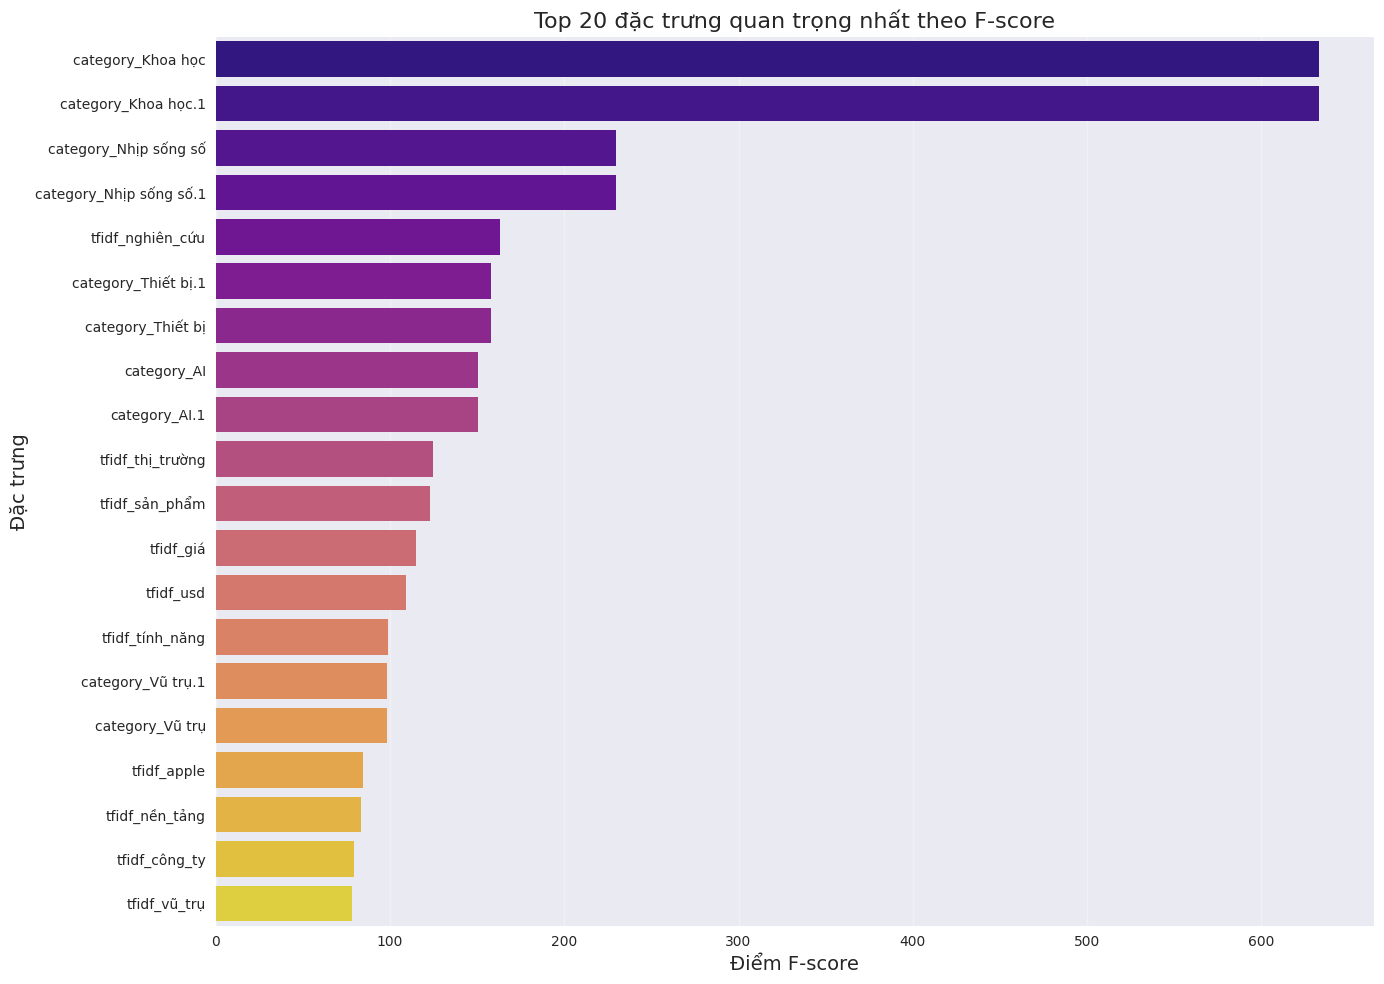

In [11]:
# Trực quan hóa top 20 đặc trưng quan trọng nhất theo F-score
plt.figure(figsize=(14, 10))
top_20_features_f = f_scores.head(20)
sns.barplot(x='f_score', y='feature', data=top_20_features_f, palette='plasma')
plt.title('Top 20 đặc trưng quan trọng nhất theo F-score', fontsize=16)
plt.xlabel('Điểm F-score', fontsize=14)
plt.ylabel('Đặc trưng', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 4.3. Giảm chiều dữ liệu với PCA

Chúng ta sẽ sử dụng kỹ thuật PCA để giảm số chiều của dữ liệu, giúp tăng tốc độ huấn luyện mô hình và giảm thiểu overfitting.

In [12]:
# Áp dụng PCA cho các đặc trưng đã được chuẩn hóa
pca = PCA(n_components=0.95)  # Giữ lại 95% phương sai
pca_result = pca.fit_transform(X_scaled)

print(f"Số lượng thành phần PCA: {pca.n_components_}")
print(f"Tỷ lệ phương sai giải thích: {pca.explained_variance_ratio_.sum():.2f}")

Số lượng thành phần PCA: 125
Tỷ lệ phương sai giải thích: 0.95


PCA dimensionality reduction output explanation:

The PCA output shows:
1. Number of PCA components selected (to preserve 95% of variance)
2. The total explained variance ratio (around 0.95 or 95%)

This means we've reduced the dimensionality while preserving most of the information 
in the dataset. The scatter plot shows the first two principal components, where each 
point represents an article. If the groups appear well-separated in this plot, it indicates 
that the reduced-dimension representation maintains good discriminative power.

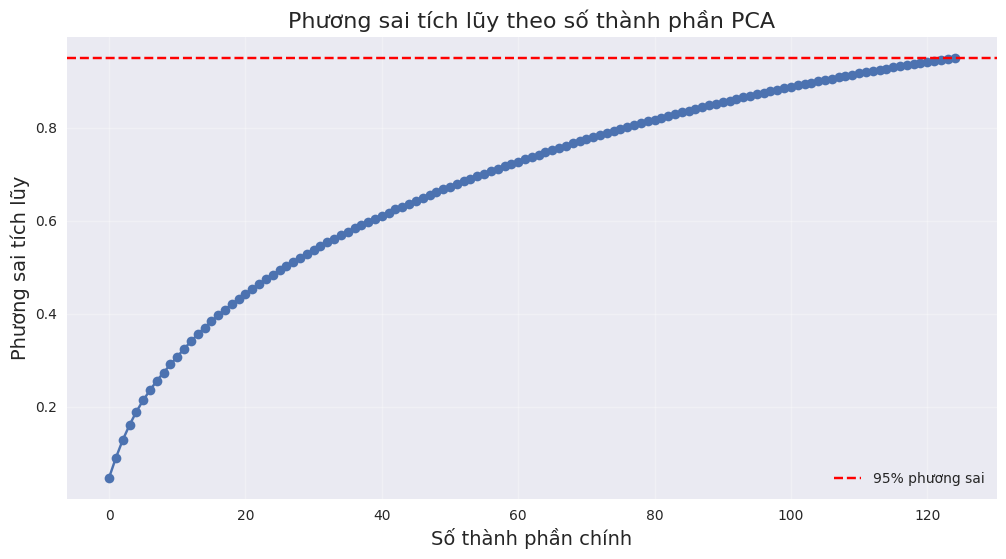

In [13]:
# Trực quan hóa phương sai tích lũy
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% phương sai')
plt.grid(True, alpha=0.3)
plt.xlabel('Số thành phần chính', fontsize=14)
plt.ylabel('Phương sai tích lũy', fontsize=14)
plt.title('Phương sai tích lũy theo số thành phần PCA', fontsize=16)
plt.legend()
plt.show()

### 4.3.1. Trực quan hóa dữ liệu sau khi giảm chiều

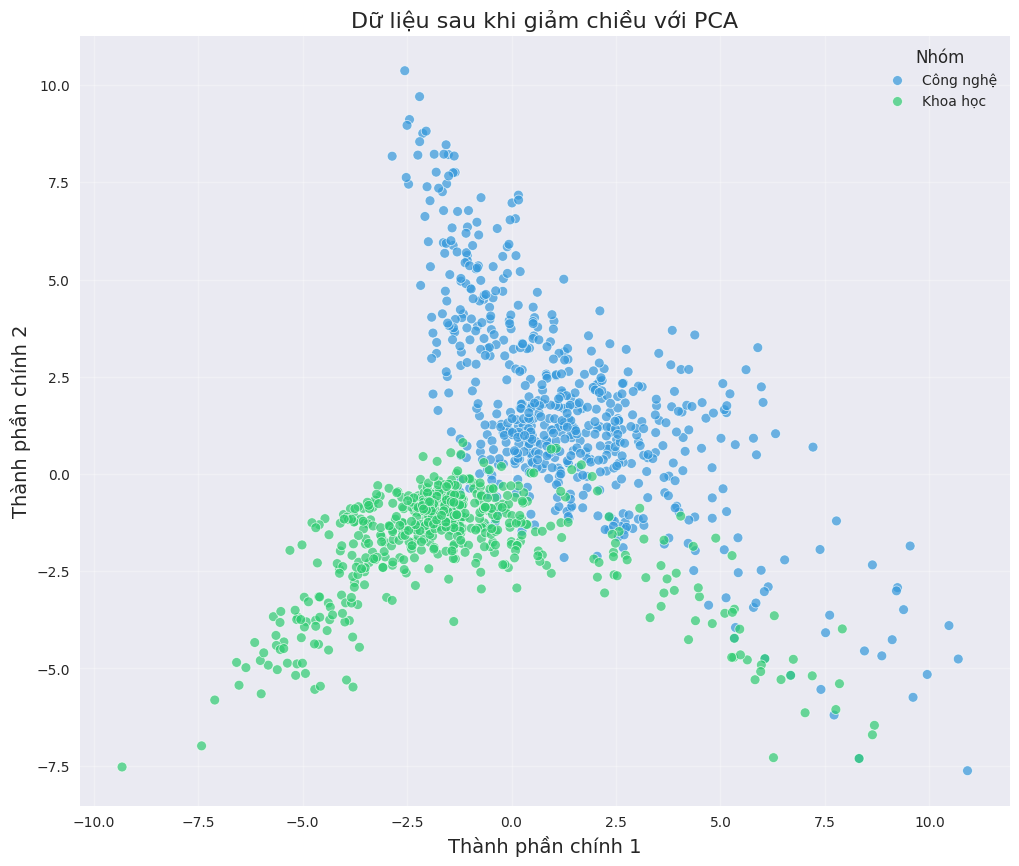

In [14]:
# Tạo DataFrame với các thành phần PCA
pca_df = pd.DataFrame(
    data=pca_result[:, :3],  # Chỉ lấy 3 thành phần đầu tiên để trực quan hóa
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['group'] = df['group']

# Trực quan hóa 2 thành phần chính đầu tiên
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='group',
    palette=['#3498db', '#2ecc71'],
    alpha=0.7,
    s=50
)
plt.title('Dữ liệu sau khi giảm chiều với PCA', fontsize=16)
plt.xlabel('Thành phần chính 1', fontsize=14)
plt.ylabel('Thành phần chính 2', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Nhóm')
plt.show()

## 4.4. Tổng hợp và lưu tập dữ liệu đặc trưng

Sau khi đã xây dựng và chọn lọc đặc trưng, chúng ta sẽ tạo một tập dữ liệu đặc trưng cuối cùng để sử dụng trong việc huấn luyện mô hình.

In [15]:
# Chọn top đặc trưng quan trọng từ cả hai phương pháp Chi2 và F-score
# Lấy 50 đặc trưng quan trọng nhất từ mỗi phương pháp
top_chi2_features = set(chi2_scores.head(50)['feature'])
top_f_features = set(f_scores.head(50)['feature'])

# Hợp nhất và loại bỏ trùng lặp
selected_features = list(top_chi2_features.union(top_f_features))
print(f"Số lượng đặc trưng được chọn: {len(selected_features)}")

# Tạo DataFrame với các đặc trưng đã chọn
df_selected_features = X_features[selected_features].copy()

# Thêm các đặc trưng tự tạo
engineered_features = ['title_content_ratio', 'desc_content_ratio', 'comments_per_content_length', 
                       'is_weekend', 'text_complexity']

for feature in engineered_features:
    if feature not in selected_features and feature in df.columns:
        df_selected_features[feature] = df[feature]
        
# Thêm biến mục tiêu
df_selected_features['group'] = df['group']

# Thêm PCA components
for i in range(min(10, pca.n_components_)):  # Chỉ lấy 10 thành phần đầu tiên
    df_selected_features[f'pca_{i+1}'] = pca_result[:, i]

# Lưu DataFrame với các đặc trưng đã chọn
df_selected_features.to_csv('../clean_data/vnexpress_featured_data.csv', index=False, encoding='utf-8-sig')
print(f"Đã lưu {df_selected_features.shape[1]} đặc trưng đã chọn cho {df_selected_features.shape[0]} bản ghi")

Số lượng đặc trưng được chọn: 64
Đã lưu 77 đặc trưng đã chọn cho 1182 bản ghi


## 4.5. Kết luận

Trong notebook này, chúng ta đã thực hiện các công đoạn xây dựng đặc trưng quan trọng:

1. **Tạo đặc trưng mới**: Chúng ta đã tạo các đặc trưng như tỷ lệ tiêu đề/nội dung, phân loại thời gian đăng bài, độ phức tạp văn bản...

2. **Phân tích tính quan trọng của đặc trưng**: Sử dụng các phương pháp Chi2 và ANOVA F-value để xác định các đặc trưng có tính phân biệt cao giữa 2 nhóm Công nghệ và Khoa học.

3. **Giảm chiều dữ liệu với PCA**: Áp dụng PCA để giảm số chiều dữ liệu, giúp tăng hiệu quả của mô hình và trực quan hóa tốt hơn.

4. **Tổng hợp đặc trưng**: Kết hợp các đặc trưng quan trọng từ nhiều phương pháp để tạo tập dữ liệu đặc trưng cuối cùng.

Những đặc trưng đã được chọn lọc này sẽ giúp ích cho việc xây dựng mô hình phân loại bài viết trong các notebook tiếp theo.